In [1]:
#for data preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
#read our dataset
df = pd.read_csv("Monthly_Avg.csv")
#show first 5 examples (in BTC)
df.head(n=5)

,Date,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
0,1/31/1978,207.8,129.2,NaN,104.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/28/1978,227.3,139.5,"44,853.1",113.3,269.5,378.8,"1,852.8",NaN,NaN,754.1,"141,796.4",869.4,"4,582.2",NaN,NaN,"111,186.6",NaN,197.0,198.6
2,3/31/1978,245.7,151.3,"49,213.2",122.5,293.2,410.6,"2,010.4",NaN,NaN,822.3,"153,099.6",939.1,"4,949.5",NaN,NaN,"118,284.0",NaN,209.9,216.7
3,4/28/1978,242.1,149.3,"49,989.4",118.8,284.2,407.3,"1,974.9",NaN,NaN,810.1,"151,068.5",926.2,"4,884.5",NaN,NaN,"116,507.1",NaN,204.4,215.9
4,5/31/1978,239.2,148.8,"51,707.2",115.4,274.2,410.5,"1,960.9",NaN,NaN,817.3,"149,744.3",919.9,"4,842.6",NaN,NaN,"115,555.9",NaN,202.8,215.8


## USD gold prices (Monthly Avg)

In [3]:
#show the distribution of the data as a histogram
data = df.USD
data = data.dropna()

In [4]:
data.shape

(546,)

In [5]:
data = [float(str(i).replace(",", "")) for i in data]
data = np.array(data)

C:\Users\91976\AppData\Local\Temp\ipykernel_21904\3745948428.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, bins=30, kde=False)


<AxesSubplot:>

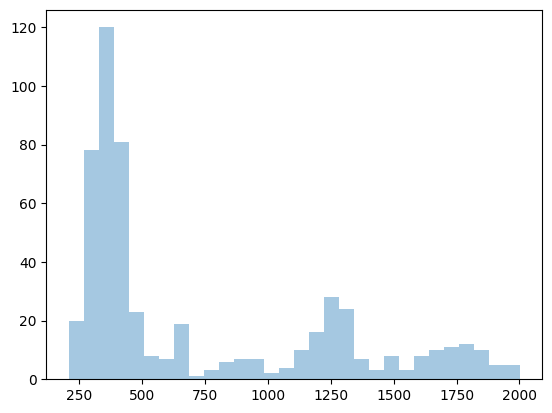

In [6]:
#plot histogram
sns.distplot(data, bins=30, kde=False)

Is the normal distribution a useful model for the data?

C:\Users\91976\AppData\Local\Temp\ipykernel_21904\4222444934.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=stats.norm, bins=30, kde=False,)


<AxesSubplot:>

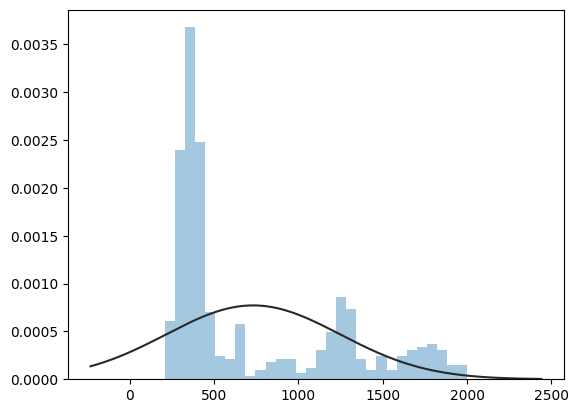

In [7]:
#try to fit a normal distribution to this data
sns.distplot(data, fit=stats.norm, bins=30, kde=False,)

MLE method

In [8]:
def gaussian_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma**2))


In [9]:
def e_step(X, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    gamma = np.zeros((len(X), 2))
    for i, x in enumerate(X):
        likelihood_1 = lambda_1 * gaussian_pdf(x, mu_1, sigma_1)
        likelihood_2 = lambda_2 * gaussian_pdf(x, mu_2, sigma_2)
        total_likelihood = likelihood_1 + likelihood_2
        gamma[i, 0] = likelihood_1 / total_likelihood
        gamma[i, 1] = likelihood_2 / total_likelihood
    return gamma


def m_step(X, gamma):
    N = len(X)
    N1 = np.sum(gamma[:, 0])
    N2 = N - N1

    lambda_1 = N1 / N
    lambda_2 = N2 / N

    mu_1 = np.sum(gamma[:, 0] * X) / N1
    mu_2 = np.sum(gamma[:, 1] * X) / N2

    sigma_1 = np.sum(gamma[:, 0] * np.abs(X - mu_1)) / N1
    sigma_2 = np.sqrt(np.sum(gamma[:, 1] * (X - mu_2)**2) / N2)

    return [lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2]


In [10]:
def log_likelihood(X, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    likelihood = lambda_1 * gaussian_pdf(X, mu_1, sigma_1) + lambda_2 * gaussian_pdf(X, mu_2, sigma_2)
    return np.sum(np.log(likelihood))

In [11]:
def em_algorithm(X, initial_theta, tol=1e-6, max_iter=100):
    theta = initial_theta
    prev_log_likelihood = None

    for i in range(max_iter):
        gamma = e_step(X, theta)
        theta = m_step(X, gamma)
        current_log_likelihood = log_likelihood(X, theta)

        if prev_log_likelihood is not None and np.abs(current_log_likelihood - prev_log_likelihood) < tol:
            break

        prev_log_likelihood = current_log_likelihood

    return theta

In [12]:
initial_theta = [0.5, 0.5, np.mean(data), np.std(data), np.median(data), np.std(data)]

In [13]:
estimated_theta_gold_avg = em_algorithm(data, initial_theta)

In [14]:
print("Estimated Parameters:")
print("lambda_1:", estimated_theta_gold_avg[0])
print("lambda_2:", estimated_theta_gold_avg[1])
print("mu_1:", estimated_theta_gold_avg[2])
print("sigma_1:", estimated_theta_gold_avg[3])
print("mu_2:", estimated_theta_gold_avg[4])
print("sigma_2:", estimated_theta_gold_avg[5])

Estimated Parameters:
lambda_1: 0.40169374200760627
lambda_2: 0.5983062579923937
mu_1: 1281.7583985938627
sigma_1: 310.3916708831984
mu_2: 362.57025657634546
sigma_2: 63.20064328767346


In [15]:
def mixture_pdf(x, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    pdf_value = lambda_1 * gaussian_pdf(x, mu_1, sigma_1) + lambda_2 * gaussian_pdf(x, mu_2, sigma_2)
    return pdf_value


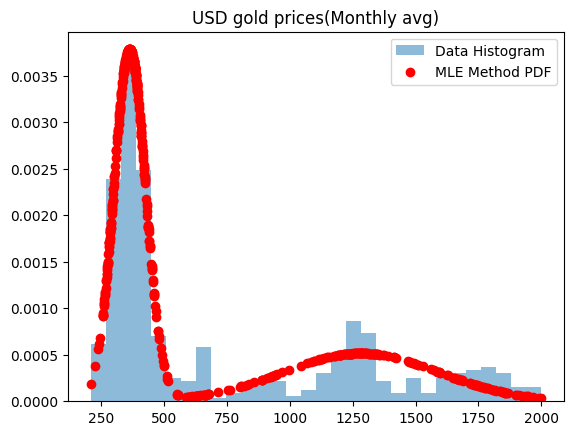

In [16]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
pdf_values_gold = mixture_pdf(data, estimated_theta_gold_avg)
plt.scatter(data, pdf_values_gold, label='MLE Method PDF', color='red')
plt.title('USD gold prices(Monthly avg)')
plt.legend()

Bayesian Method

In [17]:
from sklearn import mixture

bgmm_gold_avg = mixture.BayesianGaussianMixture(n_components=2 , max_iter = 100)
bgmm_gold_avg.fit(data.reshape(-1 , 1))

BayesianGaussianMixture(n_components=2)

In [18]:
print("Estimated Parameters:")
print("lambda_1:", bgmm_gold_avg.weights_[0])
print("lambda_2:", bgmm_gold_avg.weights_[1])
print("mu_1:", bgmm_gold_avg.means_[0])
print("sigma_1:", bgmm_gold_avg.covariances_[0])
print("mu_2:", bgmm_gold_avg.means_[1])
print("sigma_2:", bgmm_gold_avg.covariances_[1])

Estimated Parameters:
lambda_1: 0.5933236240951082
lambda_2: 0.4066763759048918
mu_1: [364.17186579]
sigma_1: [[5356.71050371]]
mu_2: [1265.7647663]
sigma_2: [[165720.87262828]]


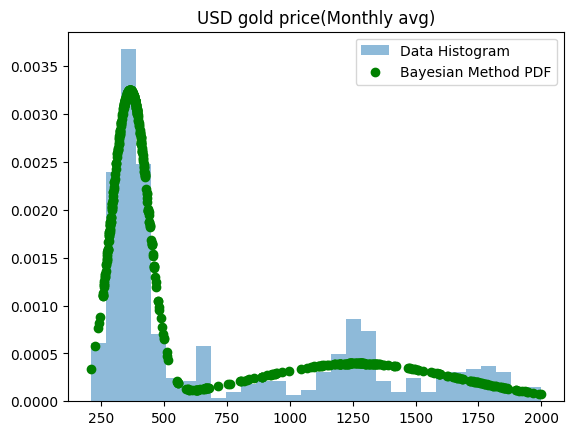

In [19]:
logprob = bgmm_gold_avg.score_samples(data.reshape(-1 , 1))
pdf_values_bay = np.exp(logprob)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('USD gold price(Monthly avg)')
plt.legend()

Plotting 2 Pdf's togather

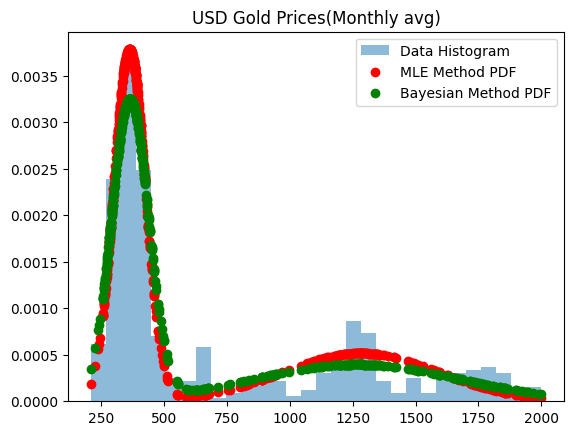

In [20]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values_gold, label='MLE Method PDF', color='red')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('USD Gold Prices(Monthly avg)')
plt.legend()

## KL Divergence between the two distributions

In [21]:
print('KL Divergence between the MLE and Bayesian distribution-->', abs(np.mean(np.log(pdf_values_gold/pdf_values_bay))))

KL Divergence between the MLE and Bayesian distribution--> 0.012187605332703685


## INR gold prices (Monthly Avg)

In [22]:
data = df.INR
data = data.dropna()

In [23]:
data.shape

(545,)

In [24]:
data = [float(str(i).replace(",", "")) for i in data]
data = np.array(data)

C:\Users\91976\AppData\Local\Temp\ipykernel_21904\491490045.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, bins=30, kde=False)


<AxesSubplot:>

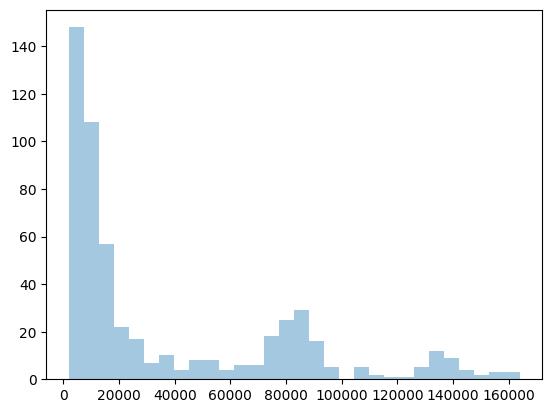

In [25]:
sns.distplot(data, bins=30, kde=False)

C:\Users\91976\AppData\Local\Temp\ipykernel_21904\3640705160.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=stats.norm, bins=30, kde=False,)


<AxesSubplot:>

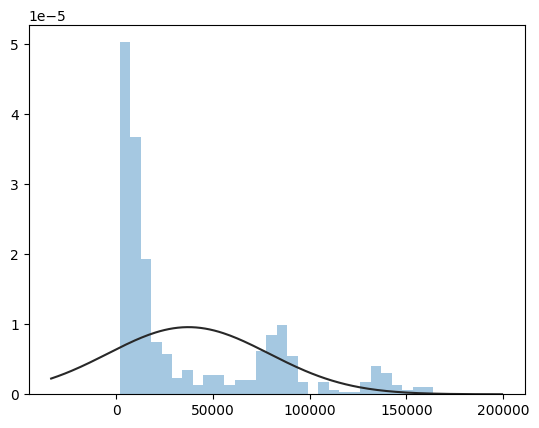

In [26]:
sns.distplot(data, fit=stats.norm, bins=30, kde=False,)

MLE method

In [27]:
initial_theta = [0.5, 0.5, np.mean(data), np.std(data), np.median(data), np.std(data)]

In [28]:
estimated_theta = em_algorithm(data, initial_theta)

In [29]:
print("Estimated Parameters:")
print("lambda_1:", estimated_theta[0])
print("lambda_2:", estimated_theta[1])
print("mu_1:", estimated_theta[2])
print("sigma_1:", estimated_theta[3])
print("mu_2:", estimated_theta[4])
print("sigma_2:", estimated_theta[5])

Estimated Parameters:
lambda_1: 0.38551788071106324
lambda_2: 0.6144821192889367
mu_1: 81451.88395350834
sigma_1: 27094.3246431848
mu_2: 9626.026586822885
sigma_2: 5027.192483561614


In [30]:
def mixture_pdf(x, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    pdf_value = lambda_1 * gaussian_pdf(x, mu_1, sigma_1) + lambda_2 * gaussian_pdf(x, mu_2, sigma_2)
    return pdf_value


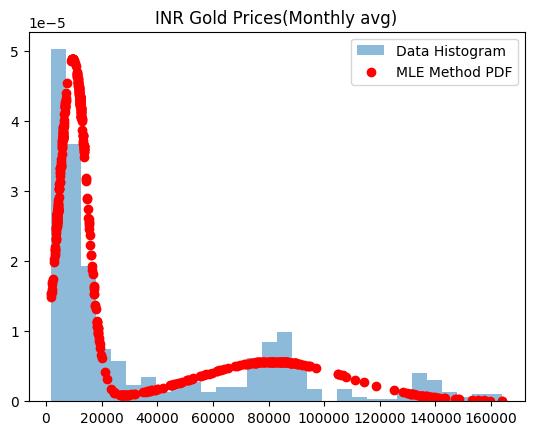

In [31]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
pdf_values = mixture_pdf(data, estimated_theta)
plt.scatter(data, pdf_values, label='MLE Method PDF', color='red')
plt.title('INR Gold Prices(Monthly avg)')
plt.legend()

Bayesian method

In [32]:
from sklearn import mixture

bgmm = mixture.BayesianGaussianMixture(n_components=2 , max_iter = 100)
bgmm.fit(data.reshape(-1 , 1))

BayesianGaussianMixture(n_components=2)

In [33]:
print("Estimated Parameters:")
print("lambda_1:", bgmm.weights_[0])
print("lambda_2:", bgmm.weights_[1])
print("mu_1:", bgmm.means_[0])
print("sigma_1:", bgmm.covariances_[0])
print("mu_2:", bgmm.means_[1])
print("sigma_2:", bgmm.covariances_[1])

Estimated Parameters:
lambda_1: 0.6085105968708505
lambda_2: 0.39148940312914954
mu_1: [9814.88410883]
sigma_1: [[34617593.95722551]]
mu_2: [79864.16056018]
sigma_2: [[1.37698335e+09]]


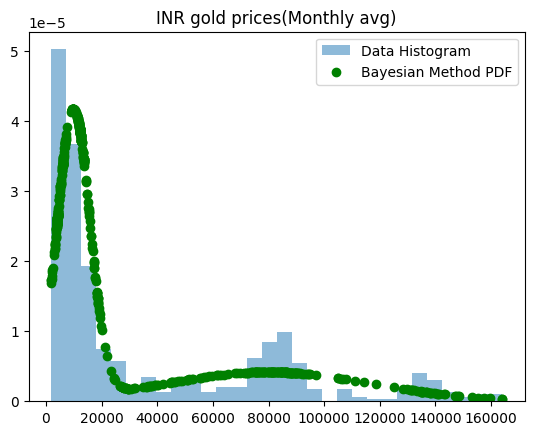

In [34]:
logprob = bgmm.score_samples(data.reshape(-1 , 1))
pdf_values_bay = np.exp(logprob)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('INR gold prices(Monthly avg)')
plt.legend()

Plotting 2 Pdf's togather

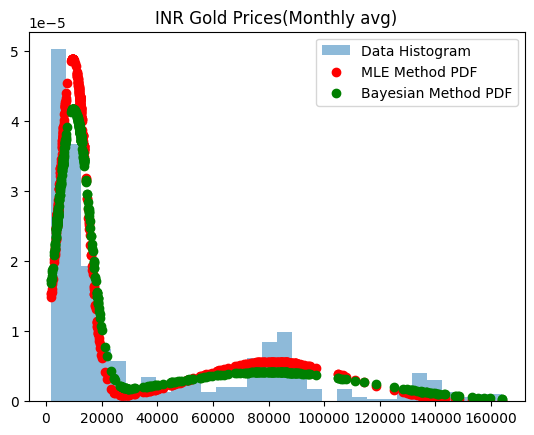

In [35]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values, label='MLE Method PDF', color='red')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('INR Gold Prices(Monthly avg)')
plt.legend()

KL Divergence between the two distributions

In [36]:
print('KL Divergence between the MLE and Bayesian distribution-->', abs(np.mean(np.log(pdf_values/pdf_values_bay))))

KL Divergence between the MLE and Bayesian distribution--> 0.02340346159487917


## Testing USD gold model on Quaterly AVG data of gold

In [37]:
df = pd.read_csv('Quarterly_Avg.csv')

In [38]:
data = df.USD
data = data.dropna()

In [39]:
data.shape

(179,)

In [40]:
data = [float(str(i).replace(",", "")) for i in data]
data = np.array(data)

C:\Users\91976\AppData\Local\Temp\ipykernel_21904\491490045.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, bins=30, kde=False)


<AxesSubplot:>

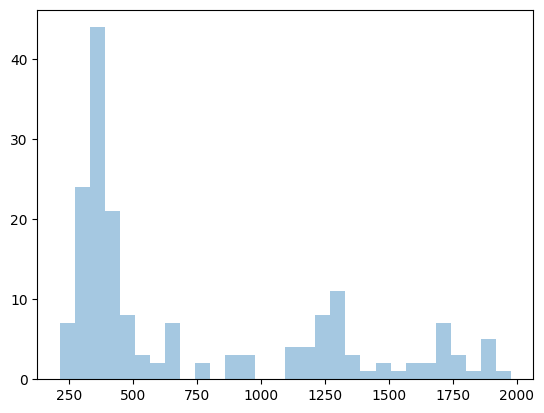

In [41]:
sns.distplot(data, bins=30, kde=False)

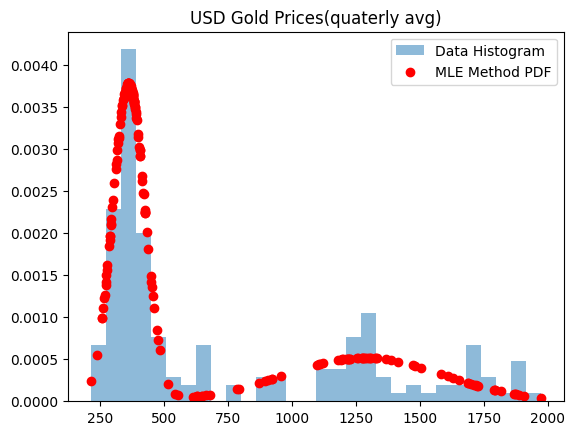

In [42]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
pdf_values = mixture_pdf(data, estimated_theta_gold_avg)
plt.scatter(data, pdf_values, label='MLE Method PDF', color='red')
plt.title('USD Gold Prices(quaterly avg)')
plt.legend()

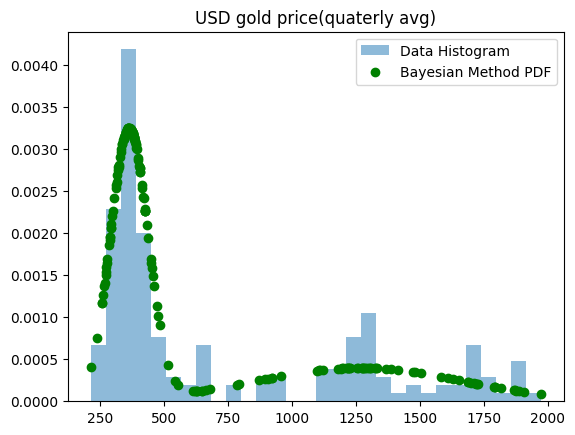

In [43]:
logprob = bgmm_gold_avg.score_samples(data.reshape(-1 , 1))
pdf_values_bay = np.exp(logprob)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('USD gold price(quaterly avg)')
plt.legend()

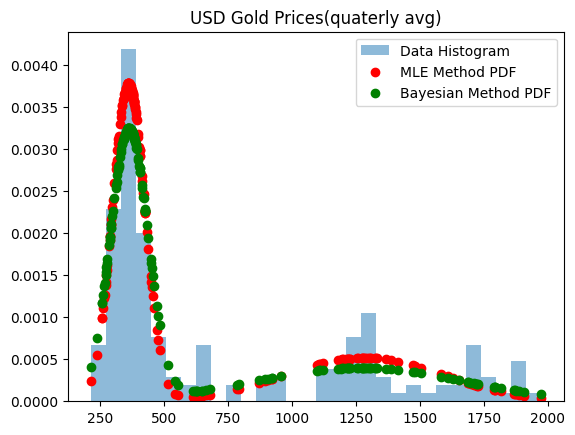

In [44]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values, label='MLE Method PDF', color='red')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('USD Gold Prices(quaterly avg)')
plt.legend()

KL Divergence between the two distributions

In [45]:
print('KL Divergence between the MLE and Bayesian distribution-->', abs(np.mean(np.log(pdf_values/pdf_values_bay))))

KL Divergence between the MLE and Bayesian distribution--> 0.01030368315095661
